In [1]:
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
from math import sin, cos, exp, inf
import random
from numba import cuda, njit, prange
import operator as op

In [5]:
# @cuda.jit(device=True)
@njit(fastmath=True)
def intersect(r0, v, p0, U, width=1000, height=1000):
    n = U.T[2]
    # checks to see if a line intersects a width x height centered on p0 with axes U.T, U.T[2] being normal to square
    num = np.dot(n, (p0-r0))
    den = np.dot(n,v)
    if den != 0:
        i = (r0 + (num/den)*v)
        ip = i-p0
        p = proj(U,ip)
        p[0] += width//2
        p[1] += height//2
        p[2] = i[2]

        if(p[0] >= 0 and p[0] < width and p[1] >= 0 and p[1] < height):
            return p
    return None

# @cuda.jit(device=True)
@njit(fastmath=True)
def proj(U, intersect):
    Uinv = np.linalg.inv(U)
    proj = np.floor(op.matmul(Uinv, intersect))
    return np.asarray([int(proj[0]), int(proj[1]), int(proj[2])])

def move(P, axis, dv):
    R = np.asarray([P[0], P[1], P[2]])
    R[axis] += dv
    return R

def rotate(U, axis, rad):
    #axis = 0,1,2 = x,y,z
    #rad is radians
    c = cos(rad)
    s = sin(rad)
    R = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
    if axis == 0:
        R = np.asarray([[1,0,0],
                        [0,c,-s],
                        [0,s,c]])
    elif axis == 1:
        R = np.asarray([[c,0,-s],
                        [0,1,0],
                        [s,0,c]])
    elif axis == 2:
        R = np.asarray([[c,-s,0],
                        [s,c,0],
                        [0,0,1]])
    return np.matmul(R,U)

In [6]:
@njit(parallel=True, fastmath=True)
def get_image(cam, height, width, vf, N, ppu, num_albums, d_ac_U, d_ac_P, d_ac_Im):
    '''
    cam is the camera location in 3d space (3 array of float64)
    vf_shp is the shape of the viewfinder centered at <0,0,0> along the xy plane (2 array of int64)
    vf is the array corresponding to the viewfinder (vf_shp[0]xvf_shp[1]x3 array of uint8)
    N is the square root of the number of samples per pixel (uint8)
    num_albums is the number of albums, (uint8)
    d_ac_U is the list of unitary matrices corresponding to each album cover (num_albumsx3x3 of float64)
    d_ac_P is the position of the center of each album cover (num_albumsx3 of float64)
    d_ac_Im is the image array of each album cover (a num_albumsx1000x1000x3 array of uint8)
    
    diffuse_vecs is the number of vectors to reflect
    diffuce_angle is the angle of diffuse reflection (in radians)
    '''
    rows_complete = np.zeros(height*ppu)
    
    for vf_x in prange(height * ppu):
        
        rows_complete[vf_x] += 1
        sum_rc = np.sum(rows_complete)
        if(sum_rc % 100 == 0):
            print(sum_rc)
            
        for vf_y in range(width * ppu):
            
            subpixels = np.asarray([0,0,0])
            input_x = vf_x/ppu - (height//2)
            input_y = vf_y/ppu - (width//2)
            
            for sp_x in range(N):
                for sp_y in range(N):
                    
                    '''
                    for every subpixel we need to:
                        1) find the closest album cover that the ray hits (if it hits anything at all)
                        2) find ~500-2500 reflected rayss off of the album cover and see what they hit
                        3) find the proportion of the reflected rays that hit the light and assign that as the 
                           brightness of that pixel
                        4) find the color of (1)
                    for every pixel:
                        1) average all the subpixels
                    '''
                    
                    dx = (sp_x/N + (0.5/N))/ppu
                    dy = (sp_y/N + (0.5/N))/ppu
                    scr_pos = np.asarray([input_x + dx, input_y + dy, 0])
                    
                    av = scr_pos - cam
                    V = av/(np.linalg.norm(av))
                    
                    neg = -100000
                    
                    min_intersect_dist = np.asarray([neg, neg, neg])
                    min_i = -1
                    
                    for i in range(num_albums):
                        intersect_i = intersect(cam, V, d_ac_P[i], d_ac_U[i])
                        if intersect_i is not None and intersect_i[2] > min_intersect_dist[2]:
                            min_intersect_dist = intersect_i
                            min_i = i
                    
                    if(min_intersect_dist[0] != neg):
                        m = min_intersect_dist
#                         print(min_i,iy,ix)
                        project_ray = d_ac_Im[min_i][m[0]][m[1]] 
                        subpixels += project_ray
            
            color_value = subpixels/(N*N)
            
            vf[vf_x][vf_y] = np.asarray(color_value)
    

In [15]:
num_albums = 5
album_covers_jpeg_names = ["tlop", "808hb", "yeezus", "grad", "dark"]
ac_U = np.zeros((num_albums,3,3), dtype="float64")
ac_P = np.zeros((num_albums,3), dtype="float64")
ac_Im = np.zeros((num_albums,1000,1000,3), dtype="uint8")
#The life of pablo, 808s and heartbreaks, yeezus, graduation, my beautiful dark twisted fanatasy

for i in range(num_albums):
    ac_U[i] = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) #U[2] is normal to the plane
    ac_P[i] = np.asarray([0,0,0])
    ac_Im[i] = np.asarray(Image.open("./album_covers/" + album_covers_jpeg_names[i] + ".jpg"))

camera_position = np.asarray([0,0,100])
height = 500
width = 500

subpixel_sampling_rate = 2 #takes this many subpixels squared
pixels_per_unit = 12 # corresponds to a (500x6) by (500x6) resolution

ac_P[0] = np.asarray([0,0,-500])
ac_P[1] = np.asarray([1000,0,-600])
ac_P[2] = np.asarray([-1000,300,-600])
ac_P[3] = np.asarray([-200,1000,-850])
ac_P[4] = np.asarray([0,-1000,-750])
ac_U[1] = rotate(ac_U[1], 2, -0.8)
ac_U[0] = rotate(ac_U[0], 0, 0.1)
ac_U[0] = rotate(ac_U[0], 1, 0.1)
ac_U[0] = rotate(ac_U[0], 2, 0.1)
ac_U[3] = rotate(ac_U[3], 1, 0.3)
ac_U[4] = rotate(ac_U[2], 2, 0.3)
ac_U[2] = rotate(ac_U[2], 0, -0.1)
ac_U[2] = rotate(ac_U[2], 1, 0.3)
ac_U[2] = rotate(ac_U[2], 2, -0.1)

100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1900.0
2000.0
2100.0
2200.0
2300.0
2400.0
2500.0
2600.0
2700.0
2800.0
2900.0
3000.0
3100.0
3200.0
3300.0
3400.0
3500.0
3600.0
3700.0
3800.0
3900.0
4000.0
4100.0
4200.0
4300.0
4400.0
4500.0
4600.0
4700.0
4800.0
4900.0
5000.0
5100.0
5200.0
5300.0
5400.0
5500.0
5600.0
5700.0
5800.0
5900.0
6000.0


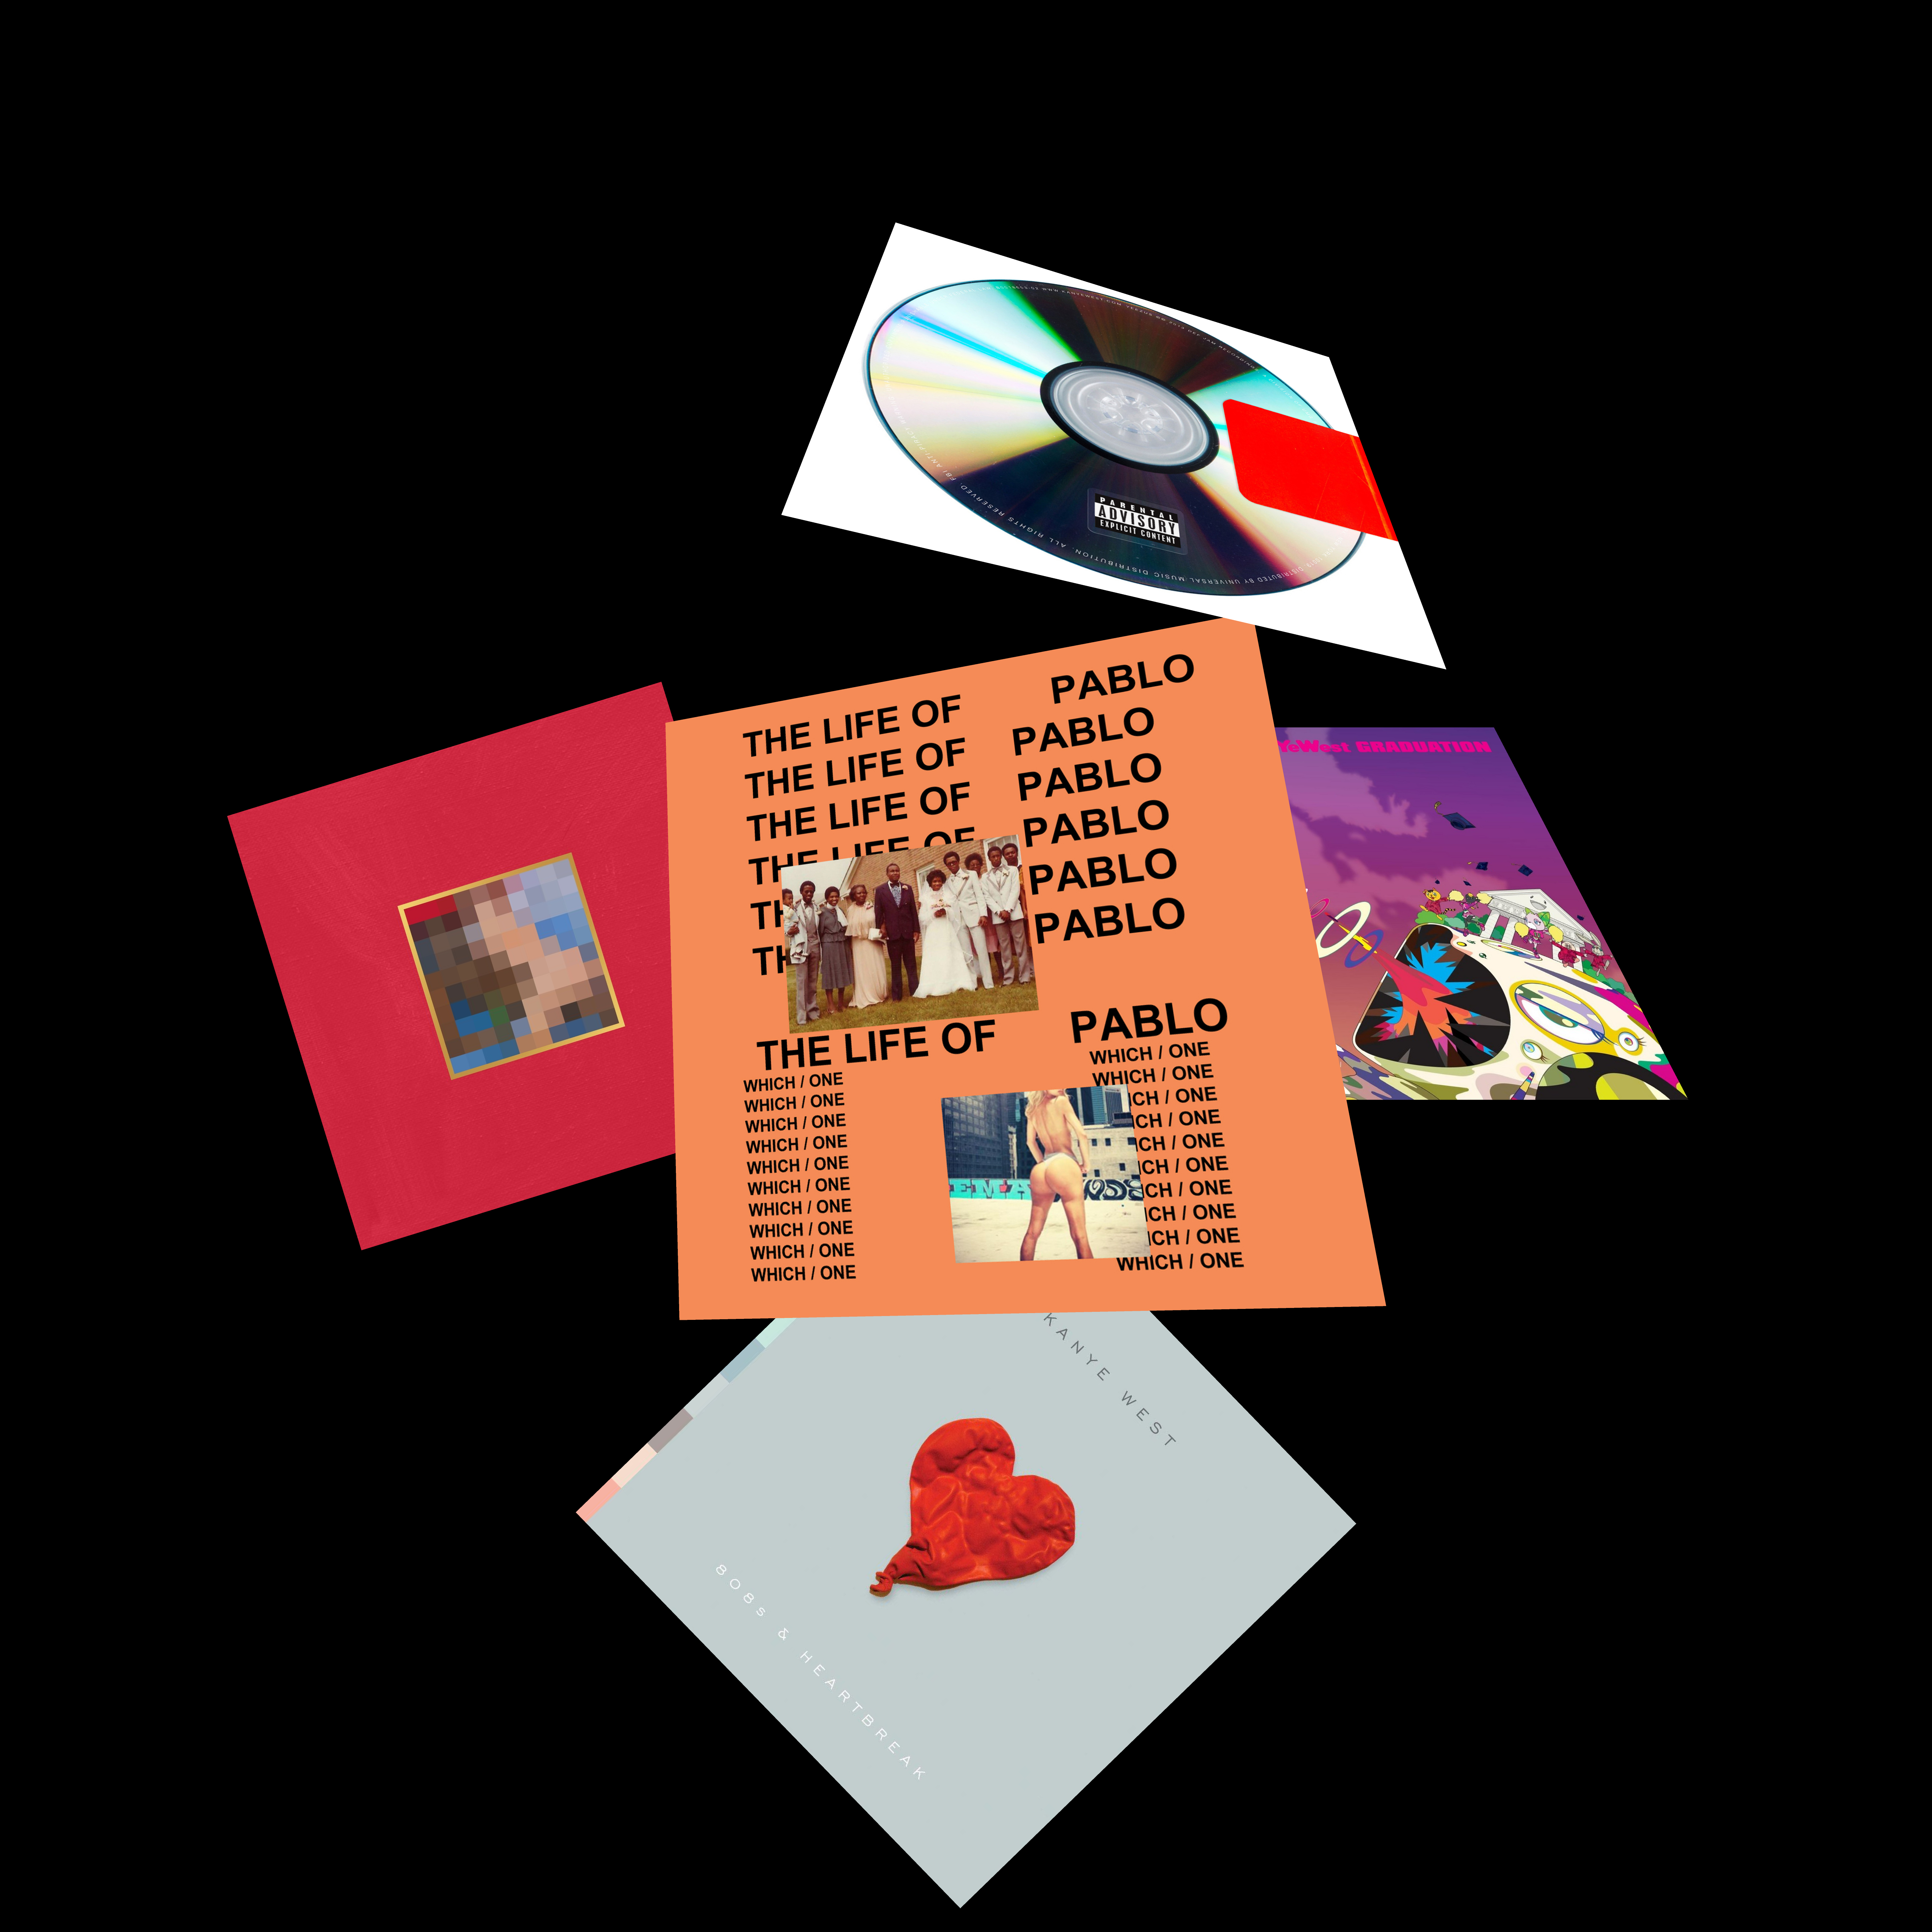

In [16]:
vf = np.zeros((height*pixels_per_unit, width*pixels_per_unit, 3))
# get_image(cam, vf_shp, vf, N, num_albums, d_ac_U, d_ac_P, d_ac_Im):
get_image(camera_position, height, width, vf, subpixel_sampling_rate, pixels_per_unit, num_albums, ac_U, ac_P, ac_Im)
vf_img = Image.fromarray(vf.astype(np.uint8))
display(vf_img)

In [17]:
vf_img.save("big_kis12_2.jpg", "JPEG")


In [87]:
def diffuse_reflection(v1, intersect, dv=1, num_vecs=30):
    '''
    this method finds an orthonormal extended off v1 (our reflected ray),
    finds num_vecs vectors within dv radians off of v1, and returns those vectors
    '''
    if num_vecs == 0:
        return 1z
    
    # gram schmidt below
    e1 = np.asarray([1.0,0,0])
    e2 = np.asarray([0,1.0,0])
    v2 = e1 - (v1*np.dot(v1,e1))
    v2 /= np.linalg.norm(v2)
    v3 = e2 - (v1*np.dot(v1,e2)) - (v2*np.dot(v2,e2))
    v3 /= np.linalg.norm(v3)

    num_rays_hit_light = 0
    
    for i in range(num_vecs):
        dt = random.random() * (2*3.1415926535) # between 0 and 2pi
        dvt = random.random() * dv
        ray1 = dvt * cos(dt)
        ray2 = dvt * sin(dt)
        s = v1 +  (ray1 * v2) + (ray2 * v3)
        
        #below is inlined sphere line intersect, i.e. rad = lsi(intersect, s, light_center, light_rad)
        direction = light_center - intersect
        n1 = np.linalg.norm(direction)
        n2 = np.dot(direction,s)
        rad = max((n1**2 - n2**2),0)**0.5
        
        if rad <= light_rad:
            num_rays_hit_light += 1
            
    return (num_rays_hit_light/num_vecs)